# DID analysis about the number of submissions

## Install and import packages

In [1]:
# 必要なパッケージをインストール
%pip install pandas statsmodels matplotlib seaborn

# パッケージの読み込み
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## Load data

In [2]:
# Load the two CSV files
file_treatment = "./submissions_Palestine_Israel_IsraelPalestine_20241026_173259.csv"
file_control = "./submissions_ps4homebrew_Exercise_voyageons_20241026_173008.csv"

# Reading the treatment and control group data
df_treatment = pd.read_csv(file_treatment)
df_control = pd.read_csv(file_control)

# Display basic information about the datasets to understand their structure
df_treatment.info(), df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2713 non-null   object
 1   title        2713 non-null   object
 2   created_utc  2713 non-null   object
 3   score        2713 non-null   int64 
 4   url          2713 non-null   object
 5   text         1593 non-null   object
dtypes: int64(1), object(5)
memory usage: 127.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1740 non-null   object
 1   title        1740 non-null   object
 2   created_utc  1740 non-null   object
 3   score        1740 non-null   int64 
 4   url          1740 non-null   object
 5   text         1588 non-null   object
dtypes: int64(1), object(5)
memory usage: 81.7+ KB


(None, None)

## Grouping data into treatment or control

In [3]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
df_treatment['created_utc'] = pd.to_datetime(df_treatment['created_utc'], utc=True)
df_control['created_utc'] = pd.to_datetime(df_control['created_utc'], utc=True)

# Add group identifier: 1 for treatment, 0 for control
df_treatment['group'] = 1
df_control['group'] = 0

# Merge both datasets for analysis
df_combined = pd.concat([df_treatment, df_control], ignore_index=True)

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
df_combined['post_treatment'] = (df_combined['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
df_combined['date'] = df_combined['created_utc'].dt.date
daily_counts = df_combined.groupby(['date', 'group', 'post_treatment']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_counts.head()

,date,group,post_treatment,submission_count
0,2024-07-28,0,0,2
1,2024-07-28,1,0,5
2,2024-07-29,0,0,16
3,2024-07-29,1,0,4
4,2024-07-30,0,0,11


## Create model and output summary

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create the interaction term for DID
daily_counts['interaction'] = daily_counts['group'] * daily_counts['post_treatment']

# Define the DID regression model: submission_count ~ group + post_treatment + interaction
did_model = ols('submission_count ~ group + post_treatment + interaction', data=daily_counts).fit()

# Output the summary of the DID regression results
did_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       submission_count   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     308.7
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           2.85e-70
Time:                        17:33:58   Log-Likelihood:                -688.46
No. Observations:                 182   AIC:                             1385.
Df Residuals:                     178   BIC:                             1398.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         18.2462      1.333     13.684      0.000      15.615      20.877
group             -9.5692      1.886     -5.075      0.000     -13.290      -5.848
post_treatment     3.0615      2.494      1.227      0.221      -1.861       7.984
interaction       70.9154      3.528     20.102      0.000      63.954      77.877
==============================================================================
Omnibus:                       60.661   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1061.599
Skew:                           0.664   Prob(JB):                    3.00e-231
Kurtosis:                      14.757   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualization

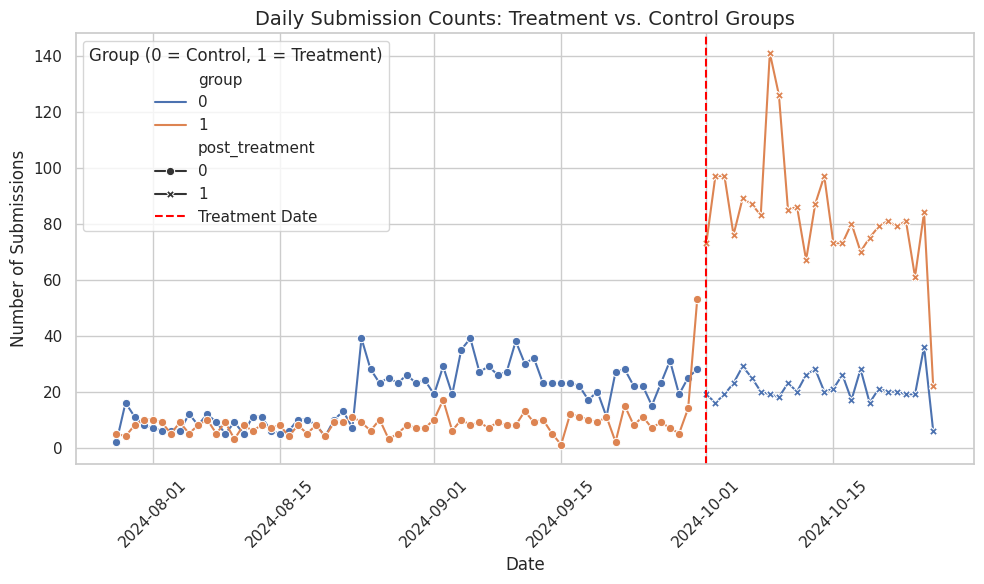

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=daily_counts, x='date', y='submission_count', hue='group', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
